In [1]:
#%% IMPORTS OF PACKAGES

import mne
import numpy as np
import pandas as pd
from os.path import join
import matplotlib.pyplot as plt
import glob
plt.ion() #toggle interactive plotting
# import numpy as np

In [2]:
data_path = "/work/MEG_data"
ID = "0147"
date_stamp = "20240926_000000"
sess = "A"

log_path = join(data_path, 'logfiles')

meg_path = join(data_path, ID, date_stamp, "MEG/001.sessA/files")
subjects_dir = "/work/freesurfer/"
raw_name = "sess" + sess + ".fif"

In [3]:
#%% READ RAW AND PLOT

raw = mne.io.read_raw_fif(join(meg_path, raw_name), preload=True)
#raw.plot() ## what happens after 10 seconds?
#raw.compute_psd(n_jobs=-1).plot()
#raw.compute_psd(n_jobs=-1, tmax=9).plot()

Opening raw data file /work/MEG_data/0147/20240926_000000/MEG/001.sessA/files/sessA.fif...
    Read a total of 9 projection items:
        planar-Raw-0.000-120.000-PCA-01 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-02 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-03 (1 x 203)  idle
        axial-Raw-0.000-120.000-PCA-01 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-02 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-03 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-04 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-05 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-06 (1 x 102)  idle
    Range : 1090000 ... 1784999 =   1090.000 ...  1784.999 secs
Ready.
Reading 0 ... 694999  =      0.000 ...   694.999 secs...


/tmp/ipykernel_570/1593384855.py:3: RuntimeWarning: This filename (/work/MEG_data/0147/20240926_000000/MEG/001.sessA/files/sessA.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(join(meg_path, raw_name), preload=True)


In [4]:
raw.filter(l_freq=None, h_freq=40, n_jobs=-1) # alters raw in-place
#raw.compute_psd(n_jobs=-1).plot()
#raw.plot()

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 331 samples (0.331 s)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 258 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 306 out of 306 | elapsed:    6.9s finished


<Raw | sessA.fif, 323 x 695000 (695.0 s), ~1.68 GB, data loaded>

In [5]:
#%% FIND EVENTS

# events = mne.find_events(raw)#, min_duration=0.002) ## returns a numpy array
events = mne.find_events(raw, min_duration=0.002,consecutive=True) ## returns a numpy array

#mne.viz.plot_events(events, sfreq=raw.info['sfreq']) ## 

2010 events found on stim channel STI101
Event IDs: [  1   2   3   4  11  12  13  14  15  16 110 120 126 130 134 140 156 210
 211 220 221 230 231 238 239 240 241 243 246 247 252 254 255]


In [6]:
trigger_vals = [1,2,3,4,110,120,130,140,210,211,220,221,230,231,240,241]
#trigger_vals = [210,211,220,221,230,231,240,241]
true_events = events[np.isin(events[:,2], trigger_vals),:]

In [7]:
event_id = {#'Visual/Deck/One': 1, # Decks presented, deck 1 marked
            #'Visual/Deck/Two': 2, # Deck 2 marked
            #'Visual/Deck/Three': 3, # Deck 3 marked
            #'Visual/Deck/Four': 4, # Deck 4 marked
            #'Visual/Win/One': 210, # Win screen, deck 1
            #'Visual/Win/Two': 220, # Win screen, deck 2
            'Visual/Win/Three': 230, # Win screen, deck 3
            #'Visual/Win/Four': 240, # Win screen, deck 4
            #'Visual/Loss/One': 211, # Loss screen, deck 1
            #'Visual/Loss/Two': 221, # Loss screen, deck 2
            'Visual/Loss/Three': 231, # Loss screen, deck 3
            #'Visual/Loss/Four': 241, # Loss screen, deck 4
            #'Response/Switch/First': 11, # y button press (switch), first
            #'Response/Switch/Second': 12, # y button press, second
            #'Response/Switch/Third': 13, # y button press, third
            #'Response/Switch/Fourth': 14, # y button press, fourth
            #'Response/Select/One': 110, # b button press (select), deck 1
            #'Response/Select/Two': 120, # b button press, deck 2
            #'Response/Select/Three': 130, # b button press, deck 3
            #'Response/Select/Four': 140, # b button press, deck 4
              }  

In [8]:
repeat_idx = np.where(np.diff(true_events[:,2])==0)[0]
repeat_idx2 = repeat_idx+1 # we need the index of both the first and the second value in those pairs (it's only the second of the two that we delete)
repeat_combined = [[i, j] for i, j in zip(repeat_idx, repeat_idx2)] # we group indices in pairs for printing

# print to inspect if needed
#print(cropped_events[repeat_combined, 2])
#print(cropped_events[repeat_combined, :])

cropped_events = np.delete(true_events, repeat_idx2, axis=0)

In [9]:
print(len(events))
print(len(cropped_events))

2010
468


In [10]:
print(len(cropped_events[cropped_events[:,2]<10,2]))
print(len(cropped_events[(cropped_events[:,2]>100) & (cropped_events[:,2]<150), 2]))
print(len(cropped_events[(cropped_events[:,2]>200) & (cropped_events[:,2]<250), 2]))

160
153
155


In [11]:
# loading in the logfiles

log_files = glob.glob(join(log_path, str(int(ID)) + sess + '*'))

df_load = []
for lf in np.sort(log_files):
    print(lf)
    df_load.append(pd.read_csv(join(log_path, lf)))
                        
df = pd.concat(df_load)

/work/MEG_data/logfiles/147A_sess_1 (2024-09-26 10-57-59).csv
/work/MEG_data/logfiles/147A_sess_2 (2024-09-26 11-01-09).csv
/work/MEG_data/logfiles/147A_sess_3 (2024-09-26 11-03-55).csv
/work/MEG_data/logfiles/147A_sess_4 (2024-09-26 11-06-38).csv


In [12]:
# cleaning the concatenated logfiles a bit

df_cropped = df.drop(['ID', 'dur_measured_decks', 'offset_decks', 'exp_type', 'offset_win'], axis=1) # throwing out columns with all NaN
df_cropped['deck_marked'] = df_cropped['init_mark'] + 1 # adjusting the indexing of "init_mark" to reflect actual deck-number rather than python index


In [13]:
# Any mismatches?
df_cropped[['deck_marked']].T.to_numpy()[0]-cropped_events[cropped_events[:,2]<10,2]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [14]:
# If you inspect these, you'll see that there was a button press trigger sent before each of these 13 triggers, 
# which for some reason messed up the reading of the trigger (to be 1 higher than it really was)
# So let's replace the deck-trigger-labels with the ones from the logfile
deck_events_idx = np.where(cropped_events[:,2]<10)[0] # what are the indices of these deck events in the cropped_events array?
print(deck_events_idx)
cropped_events[deck_events_idx, 2] = df_cropped['deck_marked']

[  0   3   6   9  11  14  17  20  23  26  29  32  35  38  41  44  46  49
  52  55  58  61  64  67  70  73  76  79  82  85  88  91  94  97 100 103
 106 109 112 115 117 120 123 126 129 132 135 138 141 144 147 150 153 156
 159 162 165 168 171 174 177 180 183 186 189 192 195 198 200 203 206 208
 211 214 217 220 223 226 229 232 235 238 241 244 247 250 253 256 259 262
 265 268 271 274 277 280 283 286 289 291 294 297 300 303 306 309 312 314
 315 318 321 324 327 330 333 336 338 341 344 347 350 353 356 359 362 365
 368 371 374 377 380 383 386 389 392 394 397 400 403 406 409 411 414 417
 420 423 426 429 432 435 438 441 444 447 450 453 456 459 462 465]


In [15]:
# fixing the deck selection labels that might be missing
#print(df_cropped[['deck_select']].T.to_numpy()[0])
deck_select = (cropped_events[(cropped_events[:,2]>100) & (cropped_events[:,2]<150), 2]/10 - 10)
deck_select_idx = np.where((cropped_events[:,2]>100) & (cropped_events[:,2]<150))[0]
#print(deck_select.astype('int'))

temp_deck_events = np.pad(cropped_events[(cropped_events[:,2]>100) & (cropped_events[:,2]<150), 2]/10 - 10,
                          (0,160-len(cropped_events[(cropped_events[:,2]>100) & (cropped_events[:,2]<150), 2]/10 - 10)), 'constant')

#print(df_cropped[['deck_select']].T.to_numpy()[0] - temp_deck_events.astype('int'))
#print(df_cropped[['deck_select']].T.to_numpy()[0] - deck_select[:160].astype('int'))

print(deck_select_idx)

[  1   4   7  12  15  18  21  24  27  30  33  36  39  42  45  47  50  53
  56  59  62  65  68  71  74  77  80  83  86  89  92  95  98 101 104 107
 110 113 116 118 121 124 127 130 133 136 139 142 145 148 151 154 157 160
 163 166 169 172 175 178 181 184 187 190 193 196 201 204 209 212 215 218
 221 224 227 230 233 236 239 242 245 248 251 254 257 260 263 266 269 272
 275 278 281 284 287 292 295 298 301 304 307 310 316 319 322 325 328 331
 334 337 339 342 345 348 351 354 357 360 363 366 369 372 375 378 381 384
 387 390 395 398 401 404 407 410 412 415 418 421 424 427 430 433 436 439
 442 445 448 451 454 457 460 463 466]


In [16]:
# longer epoching for proper ERF analysis
#reject = dict(mag=4e-12, grad=4000e-13, eog=250e-6) # T, T/m, V
reject = None
#Create the epochs
epochs = mne.Epochs(
    raw,
    cropped_events,
    event_id,
    on_missing='warn',   #only report on missing events in data, but continue script
    tmin=-0.200,
    tmax=1.000,
    baseline=(None, 0),
    reject=reject,
    preload=True,
    proj=True,
)  ## have proj True, if you wanna reject


Not setting metadata
117 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 9)
9 projection items activated
Using data from preloaded Raw for 117 events and 1201 original time points ...
0 bad epochs dropped


In [17]:
w_epochs = epochs["Visual/Win/Three"]
l_epochs = epochs["Visual/Loss/Three"]

Not setting metadata
59 matching events found
No baseline correction applied
0 projection items activated


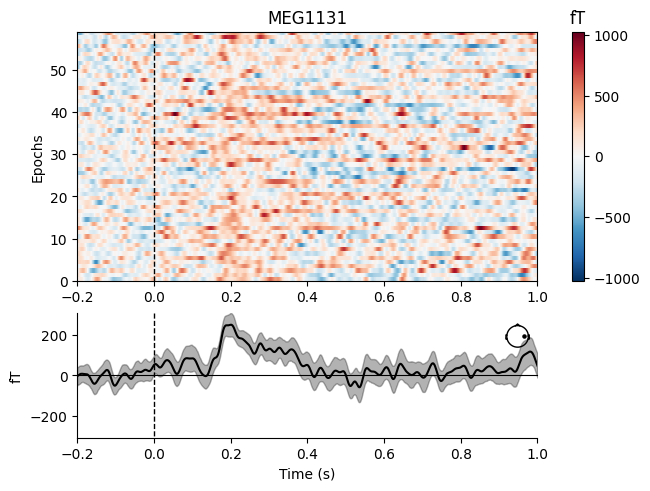

[<Figure size 640x480 with 4 Axes>]

In [18]:
w_epochs.plot_image(picks='MEG1131')

Multiple channel types selected, returning one figure per type.
combining channels using RMS (mag channels)
combining channels using RMS (mag channels)


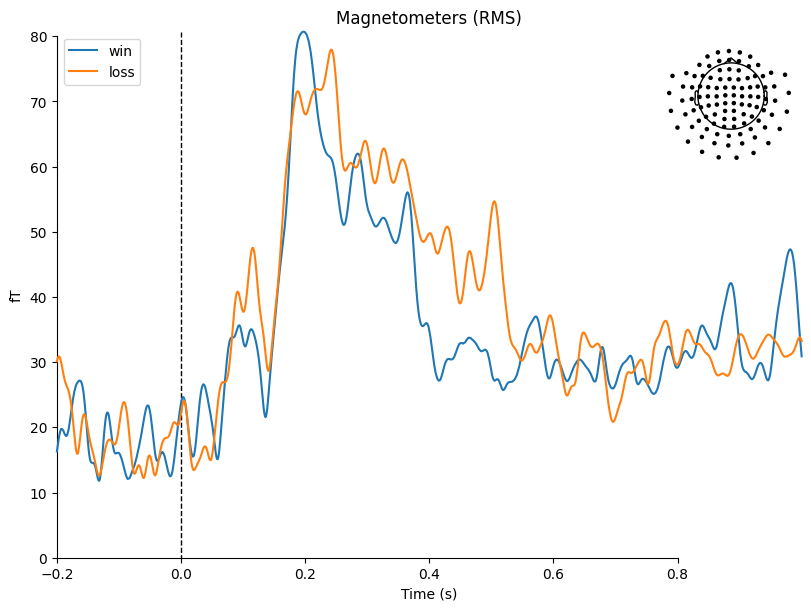

combining channels using RMS (grad channels)
combining channels using RMS (grad channels)


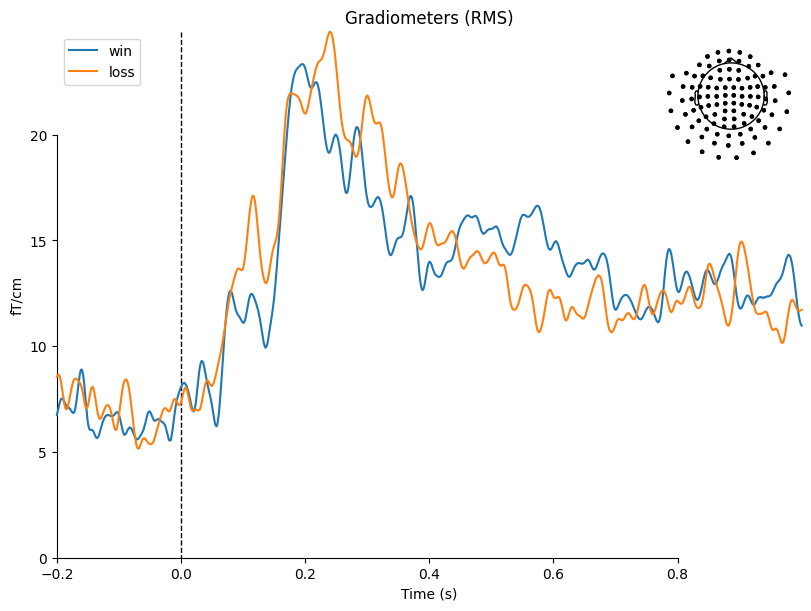

[<Figure size 800x600 with 2 Axes>, <Figure size 800x600 with 2 Axes>]

In [19]:
w_evoked = w_epochs.average()
l_evoked = l_epochs.average()

mne.viz.plot_compare_evokeds(dict(win=w_evoked, loss=l_evoked),
                             legend='upper left', show_sensors='upper right')

Projections have already been applied. Setting proj attribute to True.


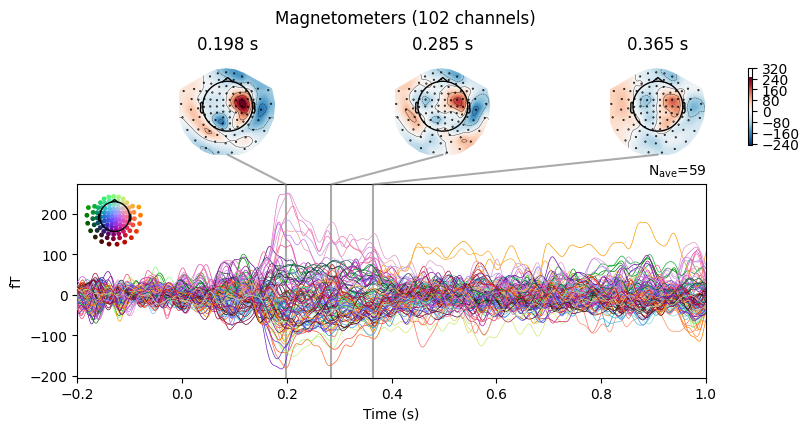

Projections have already been applied. Setting proj attribute to True.


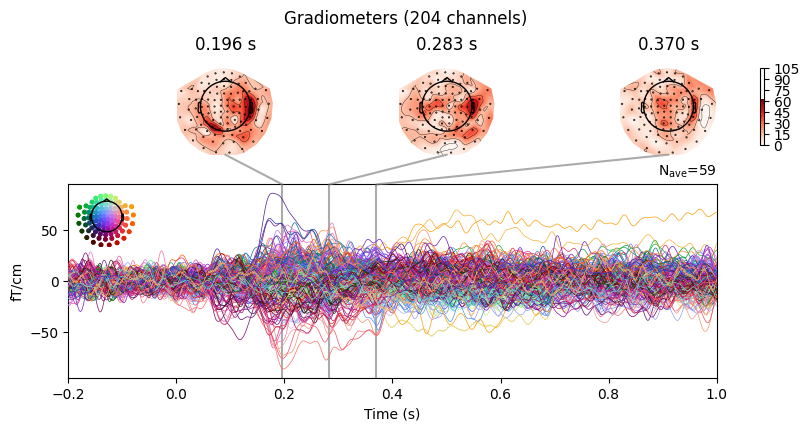

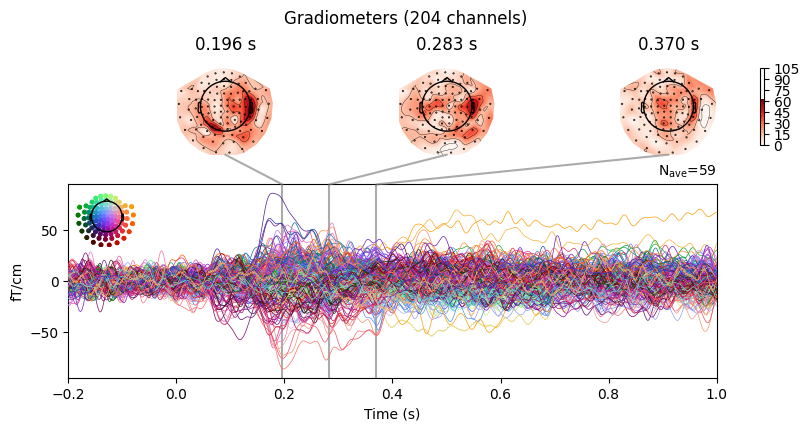

In [20]:
w_evoked.plot_joint(picks='mag')
w_evoked.plot_joint(picks='grad')
#w_evoked.plot_topomap(times=[0., 0.5, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.4], ch_type='mag')


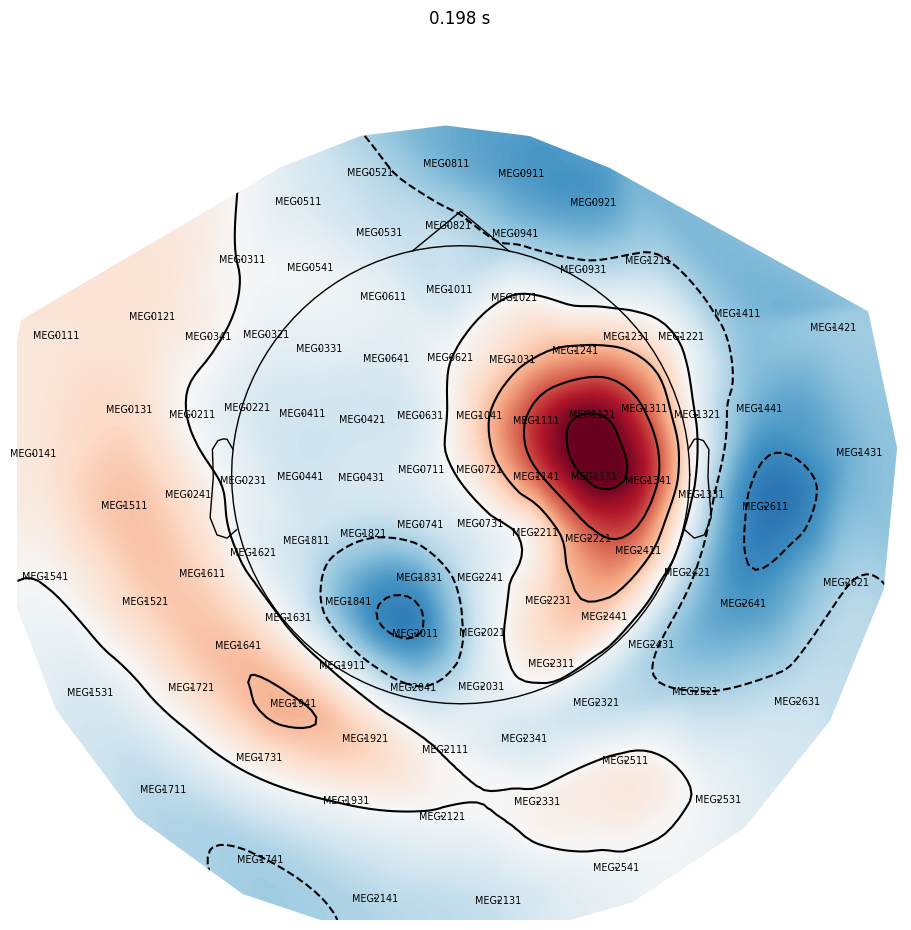

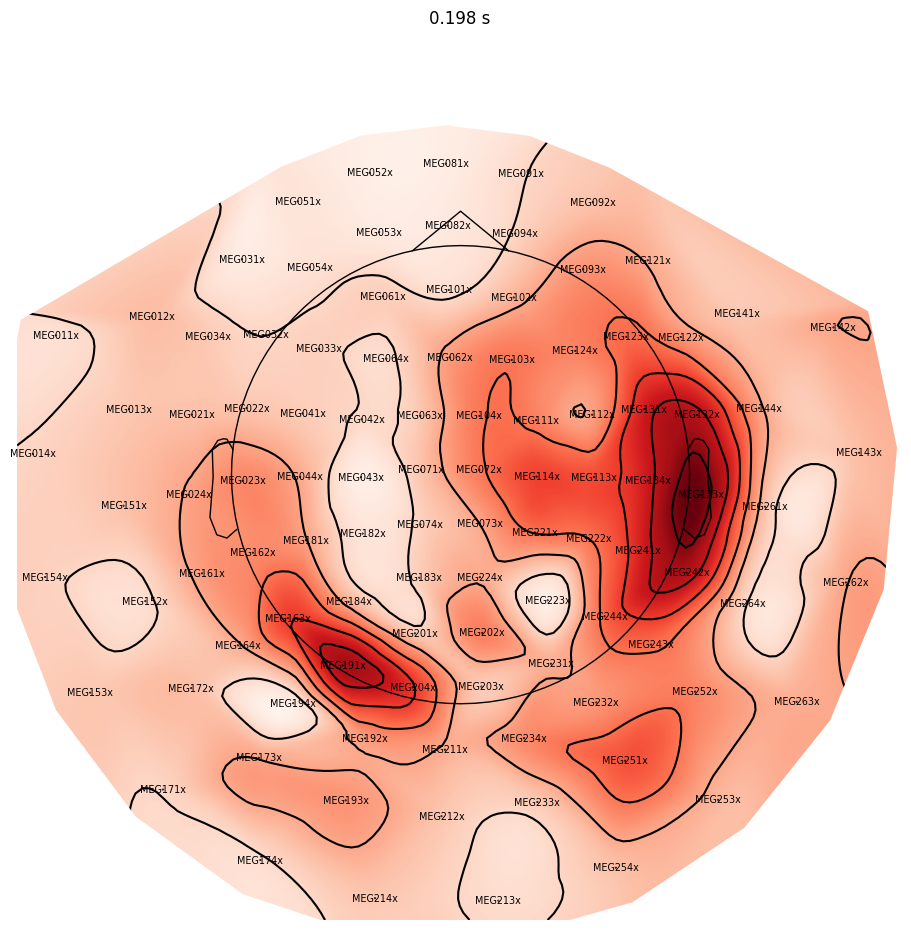

<Figure size 640x480 with 0 Axes>

In [21]:
w_evoked.plot_topomap(0.198, ch_type='mag', show_names=True, colorbar=False,
                    size=6, res=128, time_unit='s')
w_evoked.plot_topomap(0.198, ch_type='grad', show_names=True, colorbar=False,
                    size=6, res=128, time_unit='s')

plt.subplots_adjust(left=0.01, right=0.99, bottom=0.01, top=0.88)

Projections have already been applied. Setting proj attribute to True.


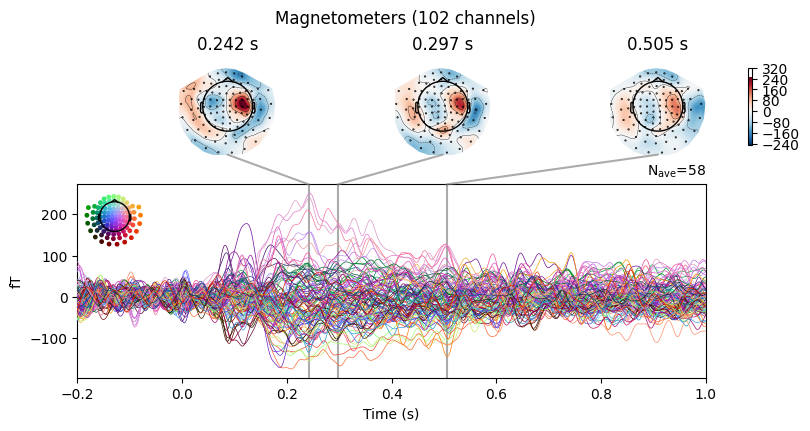

Projections have already been applied. Setting proj attribute to True.


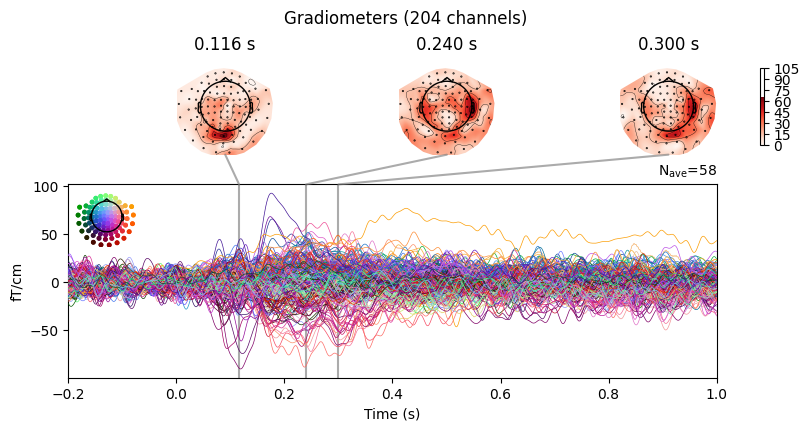

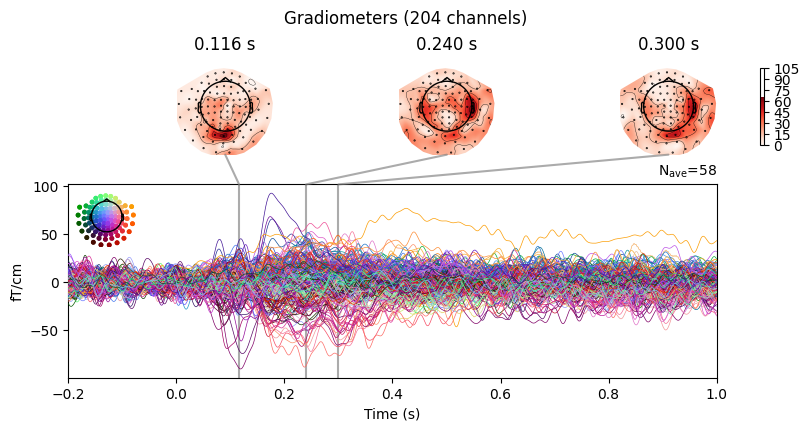

In [22]:
l_evoked.plot_joint(picks='mag')
l_evoked.plot_joint(picks='grad')
#l_evoked.plot_topomap(times=[0., 0.5, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.4], ch_type='mag')

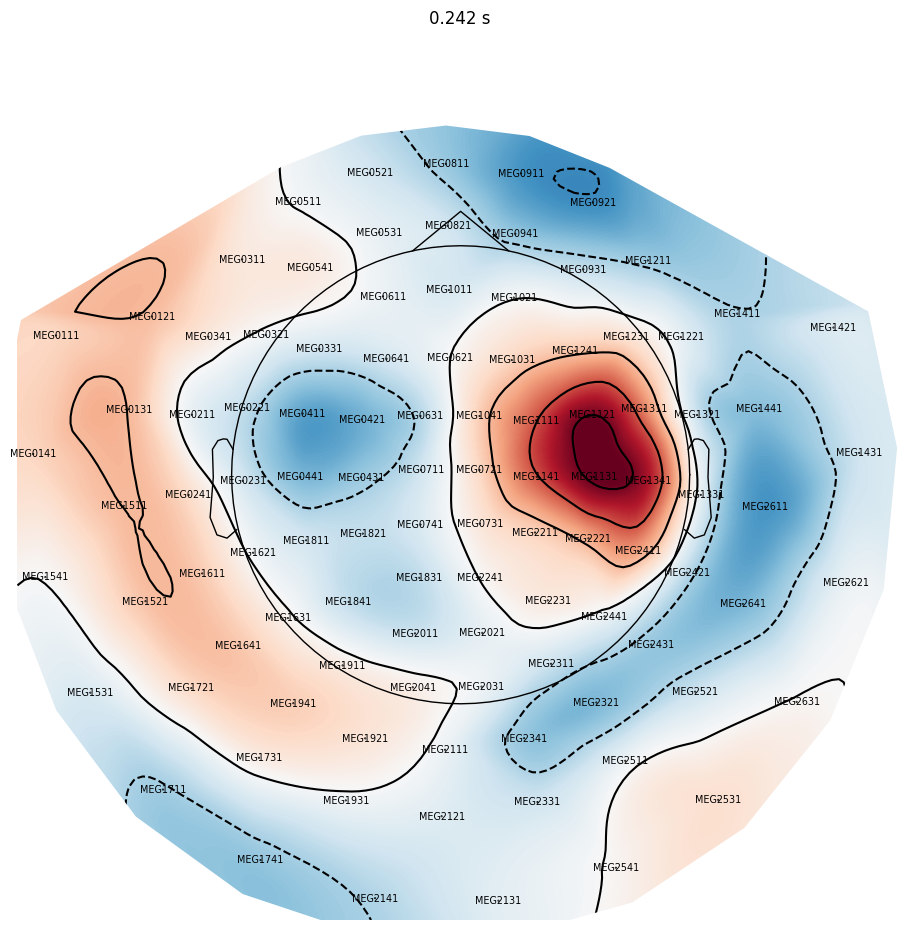

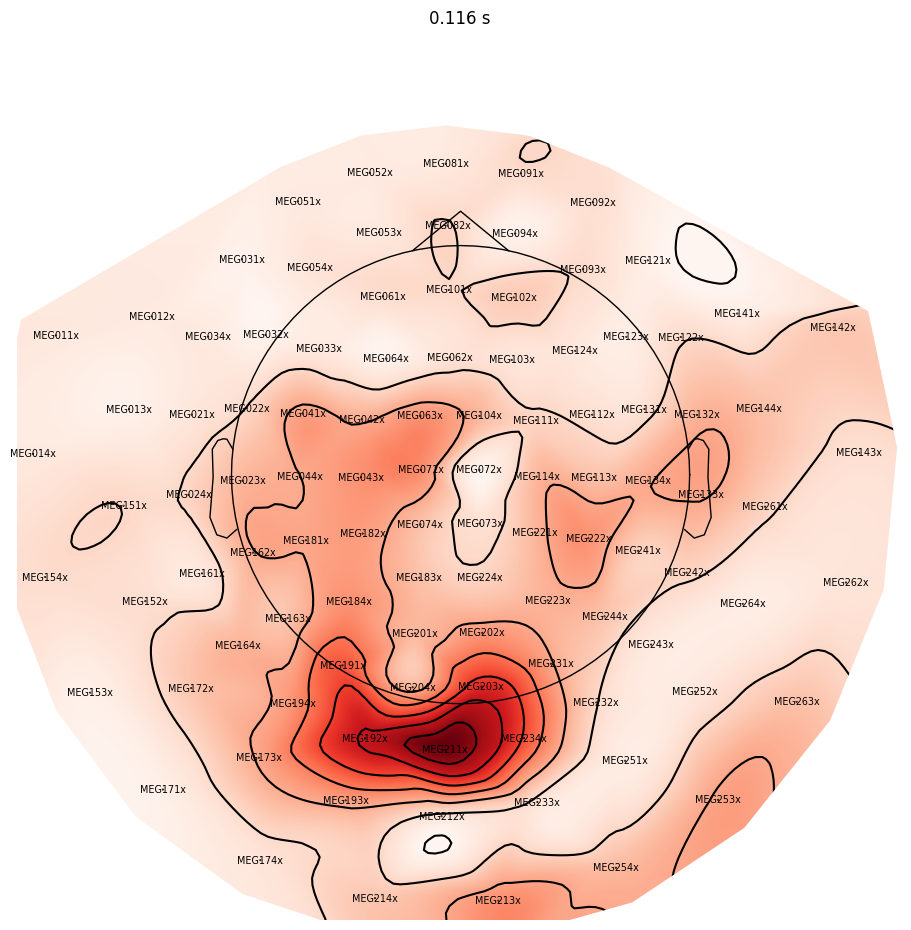

<Figure size 640x480 with 0 Axes>

In [23]:
l_evoked.plot_topomap(0.242, ch_type='mag', show_names=True, colorbar=False,
                    size=6, res=128, time_unit='s')
l_evoked.plot_topomap(0.116, ch_type='grad', show_names=True, colorbar=False,
                    size=6, res=128, time_unit='s')
plt.subplots_adjust(left=0.01, right=0.99, bottom=0.01, top=0.88)

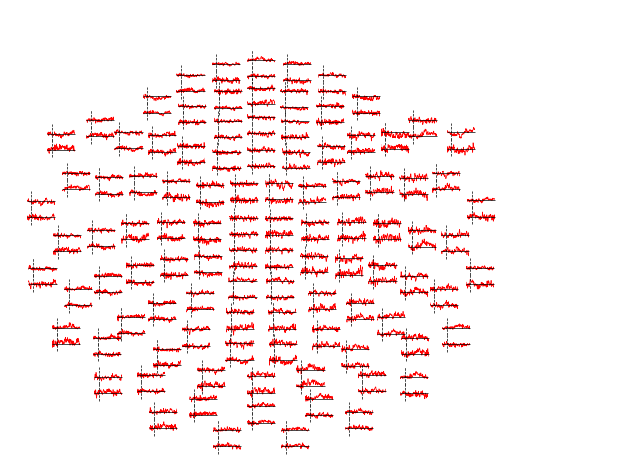

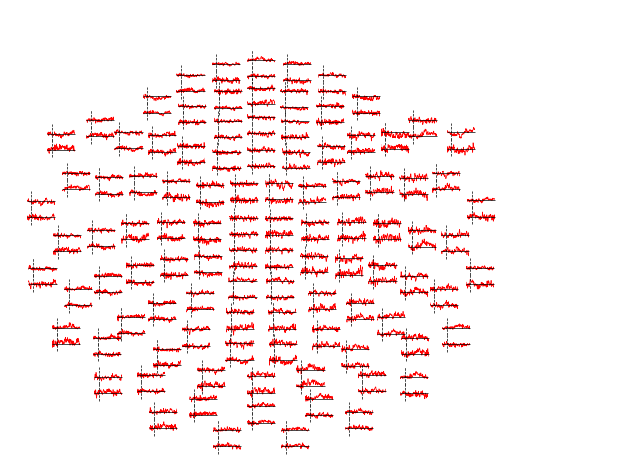

In [24]:
evoked_diff = mne.combine_evoked([w_evoked, l_evoked], weights=[1, -1])
evoked_diff.pick(picks="grad").plot_topo(color='r', legend=False)


In [25]:
import itertools
#Make list of classes to fit with our new dataset
# 1 == win, 2 == loss
condition=np.array(list(itertools.repeat(1,59))+list(itertools.repeat(2,58)))


# Concatenate using numpy
w_epochs_all = w_epochs.get_data()
l_epochs_all = l_epochs.get_data()
all_epochs_avg=np.concatenate((w_epochs_all,l_epochs_all))

In [30]:
all_epochs_avg.shape

(117, 323, 1201)

In [31]:
epochs.get_data().shape

(117, 323, 1201)

In [26]:
#%% SIMPLE CLASSIFICATION
#Set functions for classification
import numpy as np

def get_indices(y, triggers):
    indices = list()
    for trigger_index, trigger in enumerate(y):
        if trigger in triggers:
            indices.append(trigger_index)
            
    return indices

def equalize_number_of_indices(): # write this yourself
    pass

def simple_classication(X, y, triggers, penalty=None, C=1.0):

    from sklearn.linear_model import LogisticRegression
    from sklearn.preprocessing import StandardScaler
    from sklearn.model_selection import cross_val_score, StratifiedKFold
    
    n_samples = X.shape[2]
    indices = get_indices(y, triggers)
    # equalize_number_of_indices()
    X = X[indices, :, :]
    y = y[indices]
    logr = LogisticRegression(penalty=penalty, C=C, solver='newton-cg')
    sc = StandardScaler() # especially necessary for sensor space as
                          ## magnetometers
                          # and gradiometers are on different scales 
                          ## (T and T/m)
    cv = StratifiedKFold()
    
    mean_scores = np.zeros(n_samples)
    
    for sample_index in range(n_samples):
        this_X = X[:, :, sample_index]
        sc.fit(this_X)
        this_X_std = sc.transform(this_X)
        scores = cross_val_score(logr, this_X_std, y, cv=cv)
        mean_scores[sample_index] = np.mean(scores)
        #print(sample_index)
        
    return mean_scores

def plot_classfication(times, mean_scores, title=None):

    plt.figure()
    plt.plot(times, mean_scores)
    plt.hlines(0.50, times[0], times[-1], linestyle='dashed', color='k')
    plt.ylabel('Proportion classified correctly')
    plt.xlabel('Time (s)')
    if title is None:
        pass
    else:
        plt.title(title)
    plt.show()


import seaborn as sns
sns.set_style('whitegrid')


In [27]:
#%% CLASSIFCATION - COLLAPSED EVENTS

sensor_vis_win_loss_avg = simple_classication(all_epochs_avg,
                                              y = condition,
                                              triggers=[1, 2],
                                             penalty="l2",
                                             C=1e-3)

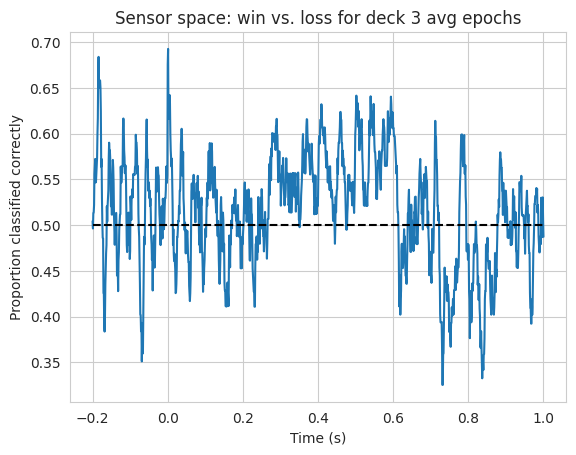

In [28]:
#%% PLOT COLLAPSED
times = epochs[0].times
plot_classfication(times, 
                   sensor_vis_win_loss_avg,
                   title='Sensor space: win vs. loss for deck 3 avg epochs')

In [114]:
#find window [201] == 0

#lets take 0.25 to 0.6 sec window


(array([205, 473]),)

In [29]:
#on non averaged epochs
X = epochs.get_data()
y = epochs.events[:, 2]   #Choose the last column

times = epochs[0].times # get time points for later

In [30]:
#%% COLLAPSE EVENTS (if you want to)
#You can assign new values to the triggers, so that you can combine several triggers into a group

def collapse_events(y, new_value, old_values=list()):
    new_y = y.copy()
    for old_value in old_values:
        new_y[new_y == old_value] = new_value
    return new_y

#First, collapse all win events and assign them value 1
y_vis_win_all = collapse_events(y, 1, [230])   #the old values get assigned the new value '1'
#Second, collapse all loss events and assign thm value 2
y_vis_win_and_loss_all = collapse_events(y_vis_win_all, 2, [231])  #the old values get assigned the new value '2'

In [31]:

sensor_vis_win_loss_all = simple_classication(X,
                                              y_vis_win_and_loss_all,
                                              triggers=[1, 2],
                                             penalty = "l2",
                                             C=1e-3)

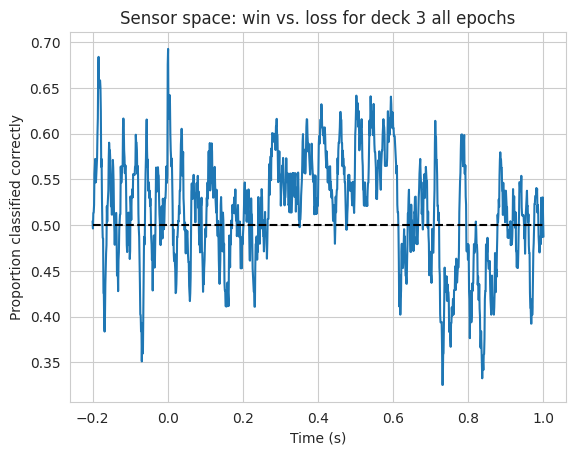

In [32]:
#%% PLOT 

plot_classfication(times, 
                   sensor_vis_win_loss_all,
                   title='Sensor space: win vs. loss for deck 3 all epochs')

In [33]:
print(sensor_vis_win_loss_all[0:201].mean())
print(sensor_vis_win_loss_all[201:451].mean())
print(sensor_vis_win_loss_all[451:601].mean())
print(sensor_vis_win_loss_all[601:801].mean())
print(sensor_vis_win_loss_all[801:1201].mean())
print(sensor_vis_win_loss_all.mean())

0.5219193885644243
0.5036724637681159
0.5480217391304347
0.5720688405797101
0.48138224637681154
0.5162313410322317


In [34]:
# %% SOURCE RECONSTRUCTION 

bem_path = "/work/freesurfer/" + "0147/bem"    
subjects_dir = "/work/freesurfer/"    #path to all subjects
fwd_name = "0147-sessA-src-fwd.fif"  
subject = '0147'

# read forward solution
fwd = mne.read_forward_solution(join(bem_path, fwd_name))
src = fwd["src"]  # where are the sources
trans = fwd["mri_head_t"]  # what's the transformation between mri and head space
info = epochs.info  # where are the sensors?
bem_sol = fwd["sol"]  # how do electric fields spread from the sources inside the head?

Reading forward solution from /work/freesurfer/0147/bem/0147-sessA-src-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523 (FIFF_MNE_FORWARD_SOLUTION_GRAD)) not available
    Read MEG forward solution (8196 sources, 306 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame


    Created an SSP operator (subspace dimension = 9)
    Setting small MEG eigenvalues to zero (without PCA)
Reducing data rank from 306 -> 297
Estimating covariance using EMPIRICAL
Done.
Number of samples used : 11859
[done]
Computing rank from covariance with rank=None
    Using tolerance 9.3e-15 (2.2e-16 eps * 102 dim * 0.41  max singular value)
    Estimated rank (mag): 96
    MAG: rank 96 computed from 102 data channels with 0 projectors
Computing rank from covariance with rank=None
    Using tolerance 2e-13 (2.2e-16 eps * 204 dim * 4.4  max singular value)
    Estimated rank (grad): 201
    GRAD: rank 201 computed from 204 data channels with 0 projectors


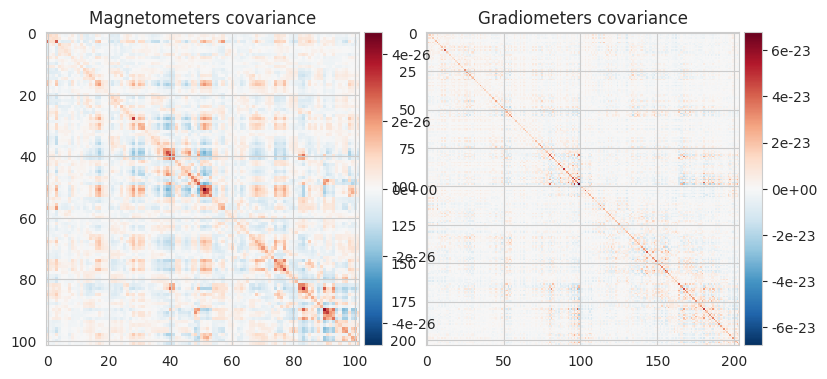

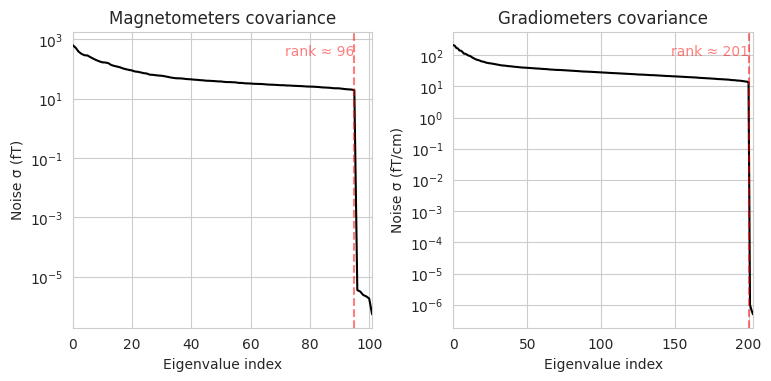

Converting forward solution to surface orientation
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 306 channels.
    306 out of 306 channels remain after picking
Selected 306 channels
Creating the depth weighting matrix...
    204 planar channels
    limit = 7826/8196 = 10.020451
    scale = 3.35804e-08 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 9)
Computing rank from covariance with rank=None
    Using tolerance 3.1e-13 (2.2e-16 eps * 306 dim * 4.5  max singular value)
    Estimated rank (mag + grad): 297
    MEG: rank 297 computed from 306 data channels with 9 projectors
    Setting small MEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and 

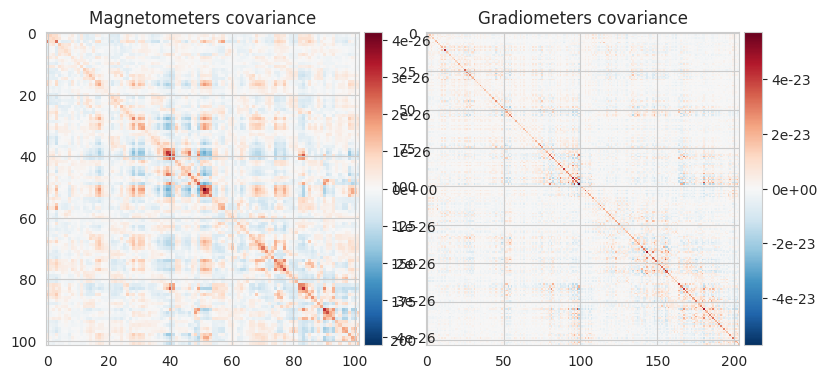

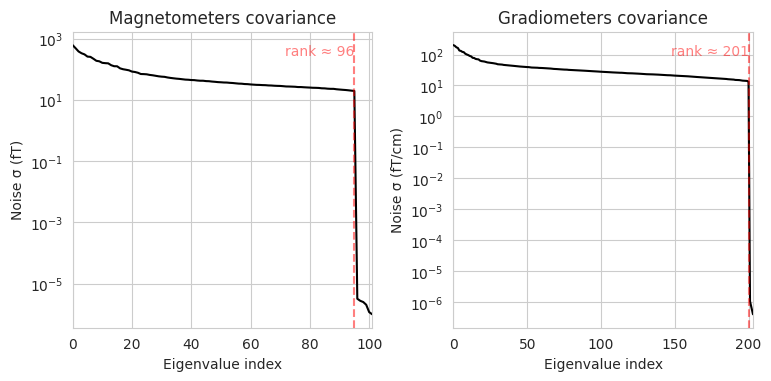

Converting forward solution to surface orientation
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 306 channels.
    306 out of 306 channels remain after picking
Selected 306 channels
Creating the depth weighting matrix...
    204 planar channels
    limit = 7826/8196 = 10.020451
    scale = 3.35804e-08 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 9)
Computing rank from covariance with rank=None
    Using tolerance 2.9e-13 (2.2e-16 eps * 306 dim * 4.3  max singular value)
    Estimated rank (mag + grad): 297
    MEG: rank 297 computed from 306 data channels with 9 projectors
    Setting small MEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and 

In [35]:
# %% estimate covariance in the baseline to whiten magnetometers and gradiometers, 
# i.e. normalizing magnetometers, gradiometers and electrode readings to make them comparable
w_noise_cov = mne.compute_covariance(w_epochs, tmax=0.000)
w_noise_cov.plot(w_epochs.info)  # not full range due to projectors projected out
# %% operator that specifies how noise cov should be applied to the fwd
w_inverse_operator = mne.minimum_norm.make_inverse_operator(w_epochs.info, fwd, w_noise_cov)
# %% estimate source time courses for evoked responses
w_stc = mne.minimum_norm.apply_inverse(w_evoked, w_inverse_operator, method="MNE")

#for loss as well
l_noise_cov = mne.compute_covariance(l_epochs, tmax=0.000)
l_noise_cov.plot(l_epochs.info)  # not full range due to projectors projected out
# %% operator that specifies how noise cov should be applied to the fwd
l_inverse_operator = mne.minimum_norm.make_inverse_operator(l_epochs.info, fwd, l_noise_cov)
# %% estimate source time courses for evoked responses
l_stc = mne.minimum_norm.apply_inverse(l_evoked, l_inverse_operator, method="MNE")


In [36]:
labels_vol = [
    #amygdala
    "Amygdala",
    #insula
    "Left-Insula",
    "Right-Insula",
    #anterior cingulate cortex
    "ctx-lh-caudalanteriorcingulate",
    "ctx-lh-rostralanteriorcingulate",
    "ctx-rh-caudalanteriorcingulate",
    "ctx-rh-rostralanteriorcingulate",
    #prefrontal cortex
    "ctx-lh-prefrontal",
    "ctx-rh-prefrontal",
    #striatum???
    "Left-Basal-Ganglia",
    "Right-Basal-Ganglia",
    #brainstem for ref?
    'Brain-Stem'
]

mri_path = "/work/freesurfer/" + "0147/mri"
fname_aseg = mri_path + "/aseg.mgz"


vol_src = mne.setup_volume_source_space(
    subject=subject,
    mri=fname_aseg,
    pos=10.0,
    bem=bem_path + '/0147-bem-sol.fif',
    volume_label=None,
    subjects_dir=subjects_dir,
    add_interpolator=True,  # just for speed, usually this should be True
    verbose=True,
)

# Generate the mixed source space
src += vol_src
print(
    f"The source space contains {len(src)} spaces and "
    f"{sum(s['nuse'] for s in src)} vertices"
)

BEM              : /work/freesurfer/0147/bem/0147-bem-sol.fif
grid                  : 10.0 mm
mindist               : 5.0 mm
MRI volume            : /work/freesurfer/0147/mri/aseg.mgz

Reading /work/freesurfer/0147/mri/aseg.mgz...


US1_J2KR.dcm:   0%|          | 38.0/154k [00:00<01:53, 1.36kB/s]
MR-SIEMENS-DICOM-WithOverlays.dcm:   0%|          | 125/511k [00:00<03:32, 2.41kB/s]
OBXXXX1A.dcm:   0%|          | 119/486k [00:00<03:34, 2.26kB/s]
US1_UNCR.dcm:   0%|          | 226/923k [00:00<04:31, 3.40kB/s]
color3d_jpeg_baseline.dcm:   0%|          | 1.50k/6.14M [00:00<07:26, 13.8kB/s]



Loaded inner skull from /work/freesurfer/0147/bem/0147-bem-sol.fif (2562 nodes)
Surface CM = (   1.6  -19.7   34.4) mm
Surface fits inside a sphere with radius  100.7 mm
Surface extent:
    x =  -67.3 ...   72.1 mm
    y = -105.6 ...   80.3 mm
    z =  -42.4 ...  100.4 mm
Grid extent:
    x =  -70.0 ...   80.0 mm
    y = -110.0 ...   90.0 mm
    z =  -50.0 ...  110.0 mm
5712 sources before omitting any.
3850 sources after omitting infeasible sources not within 0.0 - 100.7 mm.
Source spaces are in MRI coordinates.
Checking that the sources are inside the surface and at least    5.0 mm away (will take a few...)
Checking surface interior status for 3850 points...
    Found  595/3850 points inside  an interior sphere of radius   52.2 mm
    Found    0/3850 points outside an exterior sphere of radius  100.7 mm
    Found 2002/3255 points outside using surface Qhull
    Found   85/1253 points outside using solid angles
    Total 1763/3850 points inside the surface
Interior check completed in

In [37]:
## forward model as a volume
fname = join(meg_path, raw_name)
path_trans = join(bem_path, '0147-trans.fif')
output_name = bem_path + '\0147-sessA-src-fwd_vol.fif'

info = mne.io.read_info(fname)
trans = path_trans   
bem = join(bem_path, '0147-bem-sol.fif')            

fwd_vol = mne.make_forward_solution(info, trans, vol_src, bem)

    Read a total of 9 projection items:
        planar-Raw-0.000-120.000-PCA-01 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-02 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-03 (1 x 203)  idle
        axial-Raw-0.000-120.000-PCA-01 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-02 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-03 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-04 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-05 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-06 (1 x 102)  idle
Source space          : <SourceSpaces: [<volume, shape=(np.int64(16), np.int64(21), np.int64(17)), n_used=1472>] MRI (surface RAS) coords, subject '0147', ~129.4 MB>
MRI -> head transform : /work/freesurfer/0147/bem/0147-trans.fif
Measurement data      : instance of Info
Conductor model   : /work/freesurfer/0147/bem/0147-bem-sol.fif
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 1 source spaces a total of 1472 

In [38]:
#inverse model
w_inverse_operator_vol = mne.minimum_norm.make_inverse_operator(info, fwd_vol, w_noise_cov)
#inverse model
l_inverse_operator_vol = mne.minimum_norm.make_inverse_operator(info, fwd_vol, l_noise_cov)

Computing inverse operator with 306 channels.
    306 out of 306 channels remain after picking
Selected 306 channels
Creating the depth weighting matrix...
    204 planar channels
    limit = 1391/1472 = 10.100359
    scale = 4.20953e-08 exp = 0.8
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 9)
Computing rank from covariance with rank=None
    Using tolerance 3.1e-13 (2.2e-16 eps * 306 dim * 4.5  max singular value)
    Estimated rank (mag + grad): 297
    MEG: rank 297 computed from 306 data channels with 9 projectors
    Setting small MEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.
    largest singular value = 4.78427
    scaling factor to adjust the trace = 6.04245e+18 (nchan = 306 nzero = 9)
Computing inverse operator with 306 channels.
    306 out of 306 channels remain after picking
Selected 306 channels
Creating the depth 

In [39]:
from nilearn.plotting import plot_stat_map
from nilearn.image import index_img

snr = 3.0
lambda2 = 1.0 / snr ** 2
method = "dSPM"  # use dSPM method (could also be MNE or sLORETA)

#inverse_operator = read_inverse_operator(fname_inv)
w_src_vol = w_inverse_operator_vol['src']
l_src_vol = l_inverse_operator_vol['src']
# Compute inverse solution
w_stc_vol = mne.minimum_norm.apply_inverse(w_evoked, w_inverse_operator_vol, lambda2, method)
# Compute inverse solution
l_stc_vol = mne.minimum_norm.apply_inverse(l_evoked, l_inverse_operator_vol, lambda2, method)
#stc.crop(0.0, 0.2)


Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 59
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 9)
    Created the whitener using a noise covariance matrix with rank 297 (9 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Applying inverse operator to "Visual/Win/Three"...
    Picked 306 channels from the data
    Computing inverse...
    Eigenleads need to be weighted ...
    Computing residual...
    Explained  66.5% variance
    Combining the current components...
    dSPM...
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 58
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 9)
    Created the whitener using a noise covariance matrix with rank 297 (9 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Applying inverse

In [ ]:
w_stc_vol.times[200:800]

In [41]:
#timestamps between -2 and 0
minus_to_0 = w_stc_vol.times[0:201]
#timestamps between 2 and 4
zero_to_half = w_stc_vol.times[400:801]
m_t_0 = minus_to_0[0::50]
z_t_h_50 = zero_to_half[0::50]
#find og index
w_stc_vol_list = list(w_stc_vol.times)
og_indices_list = []
for j in z_t_h_50:
    if w_stc_vol_list.index(j):
        og_indices_list.append(w_stc_vol_list.index(j))

#find og index
w_stc_vol_list = list(w_stc_vol.times)
before_event_og_indices_list = []
for j in m_t_0:
    if w_stc_vol_list.index(j):
        before_event_og_indices_list.append(w_stc_vol_list.index(j))

In [61]:
for i in range(len(z_t_h_50)):
    time_in_ms = z_t_h_50[i] * 100
    folder_t =  "t_stamp_" + str(time_in_ms)
    folder_t = folder_t[0:10]
    print(folder_t)

t_stamp_20
t_stamp_25
t_stamp_30
t_stamp_35
t_stamp_40
t_stamp_45
t_stamp_50
t_stamp_55
t_stamp_60


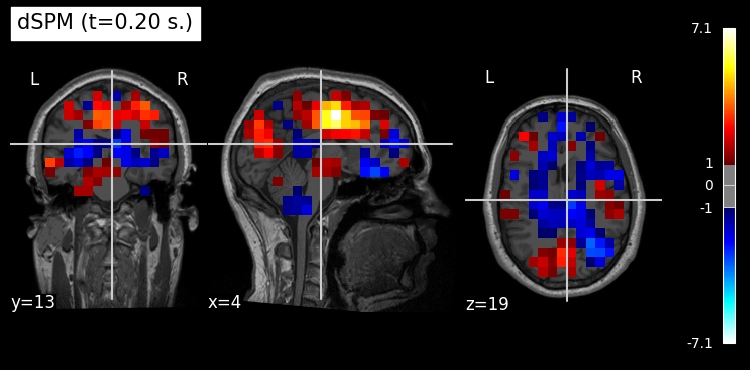

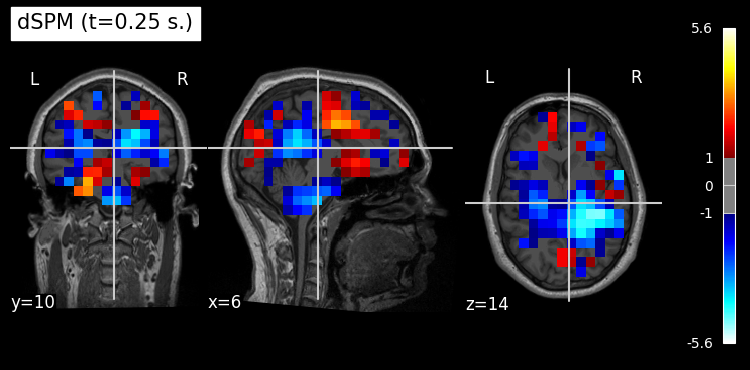

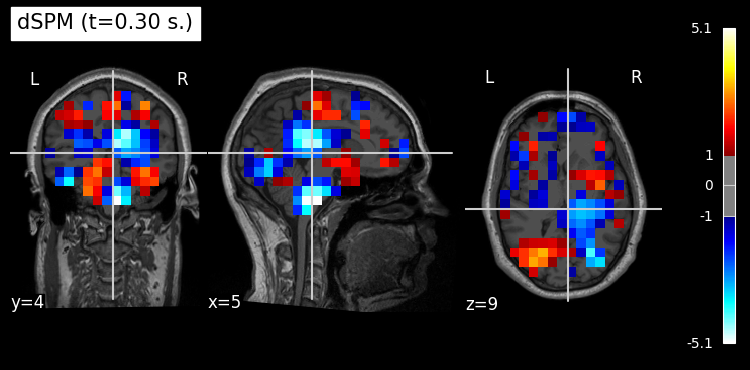

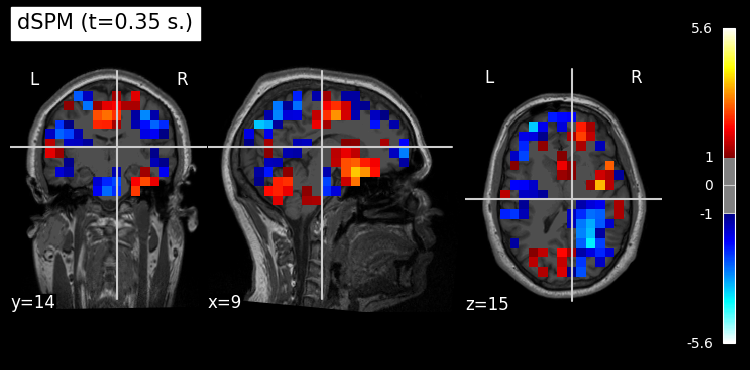

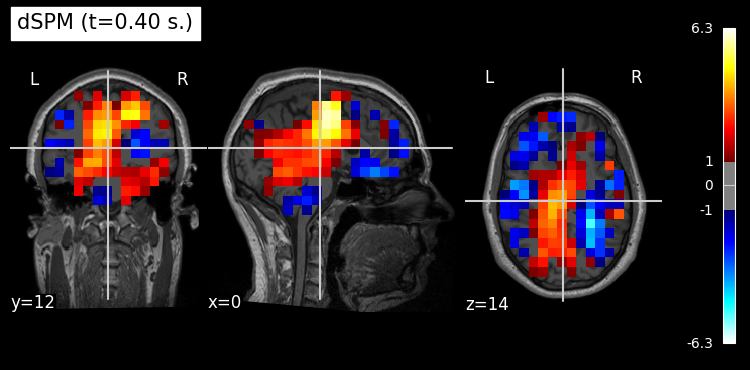

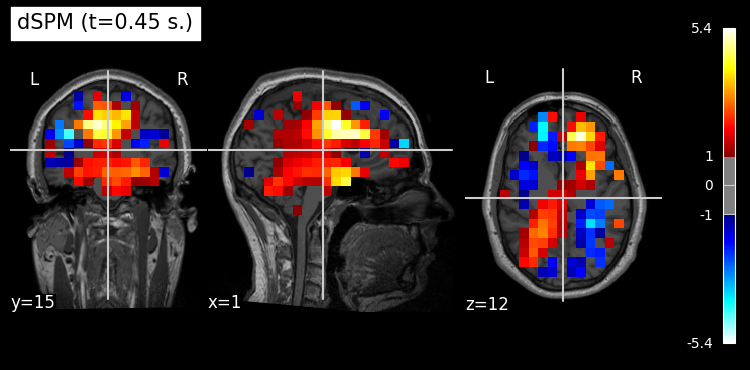

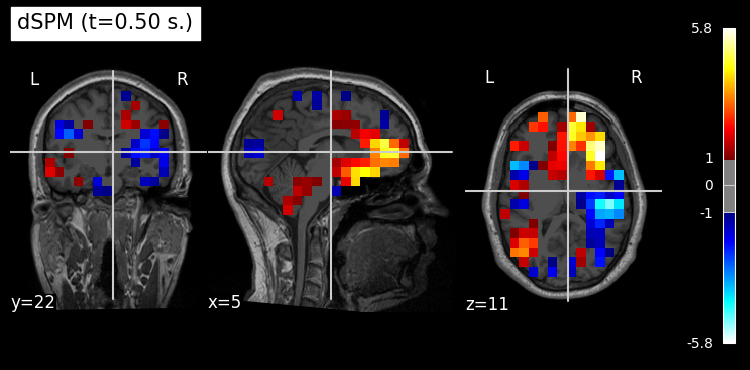

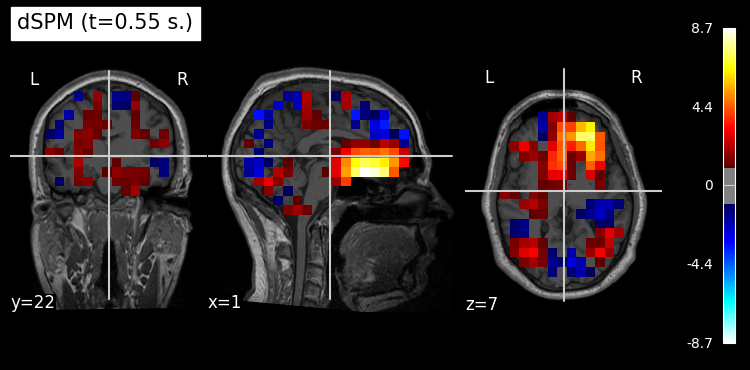

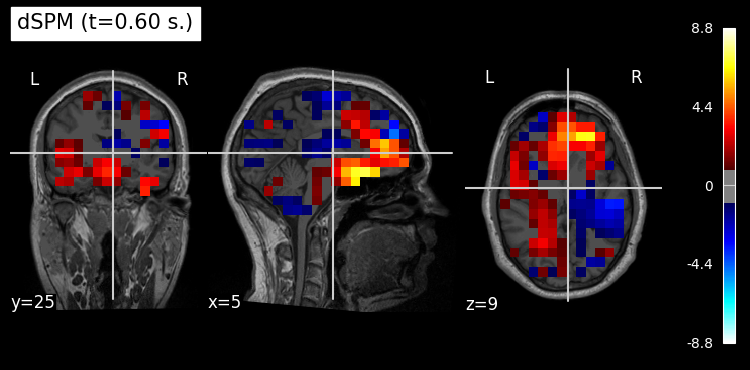

In [68]:
#Finally, we can make a plot on ucloud!
from atlasreader import create_output
from nilearn.image import math_img

# Export result as a 4D nifti object
w_img = w_stc_vol.as_volume(w_src_vol, mri_resolution=False)  # set True for full MRI resolution
l_img = l_stc_vol.as_volume(l_src_vol, mri_resolution=False)

result_img = math_img("img1 - img2",
                      img1=w_img, img2=l_img)

# Save it as a nifti file
# nib.save(img, 'mne_%s_inverse.nii.gz' % method)

t1_fname = join(mri_path, 'T1.mgz')

for i in range(len(z_t_h_50)):

    plot_stat_map(index_img(result_img, og_indices_list[i]), str(t1_fname), threshold=1.,
                  title='%s (t=%.2f s.)' % (method, z_t_h_50[i]))

    time_in_ms = z_t_h_50[i] * 100
    folder_t =  "t_stamp_" + str(time_in_ms)
    folder_t = folder_t[0:10]
    
    create_output(index_img(result_img, og_indices_list[i]), 
                  cluster_extent = 10, 
                  outdir = "./results/times" + "/" + folder_t,
                  stat_plot_kws = {"bg_img":str(t1_fname)})
    
    plt.show()


In [91]:
import os

In [88]:
#get cluster data in a df
test = pd.read_csv("./results/times/t_stamp_60/atlasreader_peaks.csv")

In [119]:
list_of_folders  = os.listdir("./results/times")[0:-1]

In [117]:
list_of_folders[1][8:10]

'20'

In [130]:
#get all
df_list = [] 
for folder in list_of_folders:
    current_path = "./results/times/" + folder + "/atlasreader_peaks.csv"

    
    df = pd.read_csv(current_path)
    df["time"] = folder[8:10]
    df_list.append(df)

df_fin = pd.concat(df_list)
 

In [140]:
df_fin = df_fin.sort_values(by=['time'])

In [144]:
df_fin.to_csv("./results/result_peaks.csv")